# Modelado de datos
## Importar bibliotecas

In [41]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import joblib

import nltk
nltk.download('vader_lexicon')
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.sentiment import SentimentIntensityAnalyzer
from pydantic import BaseModel
from typing import List, Union, Tuple , Optional
from fastapi import FastAPI, HTTPException, Depends, Query

# one hot encoding con feature-engine
#from feature_engine.encoding import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# GroupKFold en un pipeline con StandardScaler y SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, GroupKFold, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ozi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Importación de Datos

In [26]:
X_train= pd.read_csv('../datasets/processed/X_train.csv', sep=',', encoding='utf-8')
X_test= pd.read_csv('../datasets/processed/X_test.csv', sep=',', encoding='utf-8')
y_test= pd.read_csv('../datasets/processed/y_test.csv', sep=',', encoding='utf-8')
y_train= pd.read_csv('../datasets/processed/y_train.csv', sep=',', encoding='utf-8')

In [27]:
# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Shapes of training sets:
X_train: (38140, 17)
y_train: (38140, 1)

Shapes of testing sets:
X_test: (9535, 17)
y_test: (9535, 1)


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
for column in X_train.columns:
    print(f"Valores únicos en '{column}':")
    print(X_train[column].unique()[:5])
    print("="*30)

Valores únicos en 'genres_str':
['rpg' 'strategy' 'massivelymultiplayer' 'action' 'Unknown']
Valores únicos en 'app_name':
['ORION: Prelude' 'Knights of Honor' 'PlanetSide 2'
 'Battlefield: Bad Company™ 2' 'Terraria']
Valores únicos en 'release_date':
['2013-04-16' '2005-05-10' '2012-11-20' '2010-03-02' '2011-05-16']
Valores únicos en 'price':
[ 0.99000001  9.98999977 -1.         19.98999977  4.98999977]
Valores únicos en 'game_id':
[104900  25830 218230  24960 105600]
Valores únicos en 'developer':
['Trek Industries, Inc' 'Black Sea Studios Ltd' 'Daybreak Game Company'
 'DICE' 'Re-Logic']
Valores únicos en 'year':
[2013 2005 2012 2010 2011]
Valores únicos en 'user_id':
['SPACEgamer' 'NUZXD' 'greenie1995' 'silentAggressor' 'FeatInk']
Valores únicos en 'user_reviews_item_id':
[104900  25830 218230  24960 105600]
Valores únicos en 'review':
['Bascially left 4 dead 2 with dinos. The funniest part about the game is that melee weapons are more op than guns!'
 'Played as medieval Denmark, Go

### Preprocesamiento de variables ordinales, nominales y numéricas
1. **Variables Ordinales:**
    - **RECOMMEND::** Variable binaria que indica si se recomienda o no el juego (SÍ/NO). Deberías aplicar Label Encoding
2. **Variables Nominales:**
    - **GENRES_STR** Dado quelos generos son diferentes categorías sin un orden lógico. Deberías aplicar One-Hot Encoding.
    - **APP_NAME:,** Si hay diferentes tipos de cultivos, deberías aplicar One-Hot Encoding.
    - **AGENTE AISLADO:, DEVELOPER:, GAME_ID:, USER_ID:,STEAM_ID:** Identificador único sin un orden lógico variable nominal. Deberías aplicar One-Hot Encoding.
    - **USER_REVIEWS_ITEM_ID;, STEAM_ID:** Dado que es el identificador único del ítem en las reseñas de usuarios, esta variable nominal. Deberías aplicar One-Hot Encoding.

3. **Variables numéricas:**
    - **RELEASE_DATE:** Fecha de lanzamiento del juego.
    - **PRICE:** Precio del juego.
    - **YEAR:** Año de lanzamiento del juego.
    - **ITEMS_COUNT:** Cantidad de ítems.
    - **PLAYTIME_FOREVER:**Tiempo total de juego.
    - **PLAYTIME_2WEEKS:**Tiempo de juego en las últimas dos semanas.

### Datasets de Entrenamiento SentimentAnalysisProcessor

In [28]:
# Concatenar a lo largo del eje de columnas para no perder similitud entre X_train, y_train al moento de casarle el analisis de 
#Sentimientos
concat_df = pd.concat([X_train, y_train], axis=1)
concat_df.shape

(38140, 18)

In [29]:
class SentimentAnalysisProcessor:
    def __init__(self, threshold_low=-0.5, threshold_high=0.5):
        self.threshold_low = threshold_low
        self.threshold_high = threshold_high
        self.analyzer = SentimentIntensityAnalyzer()

    def process_data(self, input_df):
        # Crear una copia del DataFrame de entrada para evitar modificaciones no deseadas
        allowed_genres = ['strategy', 'indie', 'rpg', 'action', 'simulation', 'adventure']
        df_a = input_df[input_df['genres_str'].isin(allowed_genres)]
        df = df_a.copy()

        # Aplicar el análisis de sentimientos a la columna 'review'
        df['scores_review'] = df['review'].apply(lambda x: self.analyzer.polarity_scores(x)['compound'])

        # Crear la nueva columna 'score_new' según las bandas definidas
        df['score_new'] = df['scores_review'].apply(lambda x: 0 if x < self.threshold_low else (2 if x > self.threshold_high else 1))

        # Clasificar las reseñas numéricamente
        df['sentiment_numeric'] = df['score_new']

        # Clasificar las reseñas como "Positive", "Negative" o "Neutral"
        df['sentiment_more_less'] = df['score_new'].apply(lambda x: 'Positive' if x == 2 else ('Negative' if x == 0 else 'Neutral'))

        # Eliminar las columnas 'review' y 'scores_review' si es necesario
        columns_to_drop = ['review', 'scores_review', 'release_date', 'posted_date', 'item_name', 'sentiment_numeric','user_reviews_item_id','user_id','users_items_item_id']
        df = df.drop(columns=columns_to_drop)
        df['steam_id'] = df['steam_id'].astype('object')
        df['game_id'] = df['game_id'].astype('object')
        return df

# Crear una instancia de la clase
sentiment_processor = SentimentAnalysisProcessor()
# Pasar el DataFrame a la clase para el procesamiento
output_df_train = sentiment_processor.process_data(concat_df)

In [30]:
output_df_train.head(5)

,genres_str,app_name,price,game_id,developer,year,items_count,steam_id,playtime_forever,playtime_2weeks,recommend,score_new,sentiment_more_less
0,rpg,ORION: Prelude,0.99,104900,"Trek Industries, Inc",2013,868,76561197971763633,3,0,1,0,Negative
1,strategy,Knights of Honor,9.99,25830,Black Sea Studios Ltd,2005,336,76561198061406190,0,0,1,1,Neutral
3,action,Battlefield: Bad Company™ 2,19.99,24960,DICE,2010,66,76561198059260834,252,0,1,0,Negative
4,rpg,Terraria,9.99,105600,Re-Logic,2011,33,76561198059257958,3950,0,1,2,Positive
5,strategy,Medieval II: Total War™,19.99,4700,"The Creative Assembly,Feral Interactive (Mac),...",2006,100,76561197971662256,0,0,1,2,Positive


### Datasets de Prueba SentimentAnalysisProcessor

In [31]:
concat_df2 = pd.concat([X_test, y_test], axis=1)
output_df_test = sentiment_processor.process_data(concat_df2)

### Datasets de Entrenamiento - Escalamiento de variables ordinales, nominales y numéricas

In [32]:
# Definir la clase MultiColumnLabelEncoder
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.label_encoders = {}

    def fit(self, X, y=None):
        for col in self.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        for col in self.columns:
            le = self.label_encoders[col]
            X.loc[:, col] = le.transform(X[col])
        return X

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.numeric_columns = []
        self.ordinal_columns = []
        self.categorical_columns = []

    def fit(self, X, y=None):
        # Obtener las columnas numéricas, ordinales y categóricas
        self.numeric_columns = X.select_dtypes(include=['int64', 'float64', 'int32']).columns
        self.ordinal_columns = ['recommend']  # Puedes añadir aquí tus columnas ordinales
        self.categorical_columns = X.select_dtypes(include=['object']).columns
        return self

    def transform(self, X):
        # Crear una nueva variable excluyendo las columnas ordinales
        categorical_col_excluded_ordinal = [col for col in self.categorical_columns if col not in self.ordinal_columns]
        numeric_col_excluded_ordinal = [col for col in self.numeric_columns if col not in self.ordinal_columns]

        # Convertir las columnas categóricas a tipo str
        X.loc[:, categorical_col_excluded_ordinal] = X[categorical_col_excluded_ordinal].astype(str)

        # Definir las transformaciones para las columnas numéricas
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        # Definir las transformaciones para las columnas ordinales
        ordinal_transformer = MultiColumnLabelEncoder(columns=self.ordinal_columns)

        # Aplicar las transformaciones
        transformed_data = numeric_transformer.fit_transform(X[numeric_col_excluded_ordinal])
        transformed_data = np.concatenate([transformed_data, ordinal_transformer.fit_transform(X[self.ordinal_columns])], axis=1)

        # Obtener los nombres de las columnas después de la transformación
        numeric_feature_names = numeric_transformer.named_steps['scaler'].get_feature_names_out(input_features=numeric_col_excluded_ordinal)
        ordinal_feature_names = self.ordinal_columns
        column_names = np.concatenate([numeric_feature_names, ordinal_feature_names])

        return transformed_data, column_names



def process_dataframe(input_df: pd.DataFrame, columns_to_drop: list) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    # Create an instance of the class
    label_processor = MultiColumnLabelEncoder() 
    custom_processor = CustomPreprocessor()

    # Drop specified columns
    processed_df = input_df.drop(columns=columns_to_drop)

    # Apply the pipeline to the DataFrame
    transformed_data, column_names = custom_processor.fit_transform(processed_df)

    return processed_df, pd.DataFrame(transformed_data, columns=column_names)

# Example usage
columns_to_drop = ['app_name','game_id' , 'developer', 'steam_id', 'sentiment_more_less']
processed_df, transformed_df_train = process_dataframe(output_df_train, columns_to_drop)

### Datasets de Prueba - Escalamiento de variables ordinales, nominales y numéricas

In [33]:
processed_df, transformed_df_test = process_dataframe(output_df_test, columns_to_drop)

In [39]:
transformed_df_test.head(5)

,price,year,items_count,playtime_forever,playtime_2weeks,score_new,recommend
0,0.340073,0.765206,0.436702,-0.132357,-0.102128,-0.640026,1.0
1,-0.412331,-1.573846,-0.470005,-0.397643,-0.102128,0.933161,1.0
2,-0.036129,-0.534267,-0.451608,-0.373783,-0.102128,-0.640026,1.0
3,-1.239223,0.505312,5.543177,-0.397643,-0.102128,-0.640026,0.0
4,-1.239223,1.284996,-0.341227,-0.393545,-0.102128,0.933161,1.0



### Datasets de Entrenamiento - Balanceo de Clases `review.recommend`

In [34]:
# Definir la variable objetivo "recommend" codificada
y_df_train = transformed_df_train[['recommend']]

# Seleccionar el resto de las columnas (variables predictoras) y eliminar la columna
X_df_train= transformed_df_train.drop(columns=['recommend'])


In [35]:
y_df_train.head(5)

,recommend
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


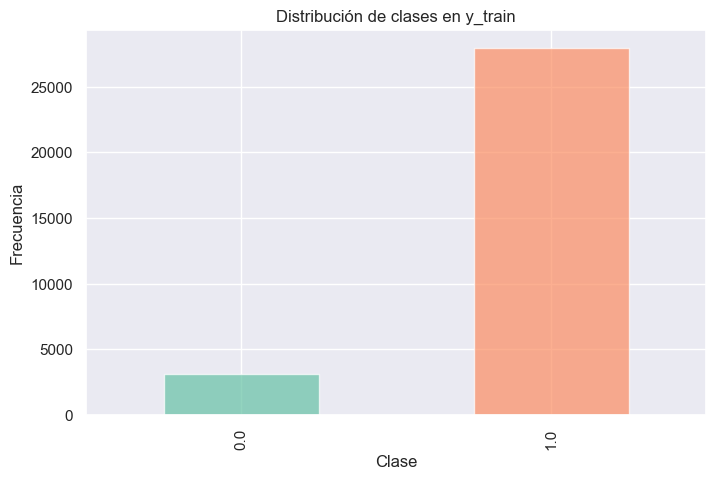

In [36]:
# Establecer el estilo y la paleta de colores
sns.set(style="darkgrid")
palette = "Set2"

# Crear un gráfico de barras para la columna 'biopsia'
plt.figure(figsize=(8, 5))
y_df_train['recommend'].value_counts().sort_index().plot(kind='bar', color=sns.color_palette(palette), alpha=0.7)
plt.title('Distribución de clases en y_train')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

In [40]:
# Verificar el balance de clases en los conjuntos de entrenamiento y prueba
print("Distribución de clases en X_train:")
if len(X_df_train) > 0:
    print(pd.Series(X_df_train.values.flatten()).value_counts())
else:
    print("El conjunto de entrenamiento está vacío.")

print("\nDistribución de clases en y_train:")
if len(y_df_train) > 0:
    print(pd.Series(y_df_train.values.flatten()).value_counts())
else:
    print("El conjunto de prueba está vacío.")


Distribución de clases en X_train:
-0.099381    30347
 0.936373    15072
-0.619992    13317
-0.027091     6439
-0.029261     6090
             ...  
-0.383390        1
-0.367925        1
-0.386284        1
 0.018949        1
 0.048827        1
Name: count, Length: 1036, dtype: int64

Distribución de clases en y_train:
1.0    27930
0.0     3150
Name: count, dtype: int64


### Datasets de Prueba - Balanceo de Clases `review.recommend`

In [42]:
# Definir la variable objetivo "recommend" codificada
y_df_test = transformed_df_test[['recommend']]

# Seleccionar el resto de las columnas (variables predictoras) y eliminar la columna
X_df_test= transformed_df_test.drop(columns=['recommend'])

In [70]:
y_df_test.head(5)

,recommend
0,1.0
1,1.0
2,1.0
3,0.0
4,1.0


In [56]:
X_train = X_df_train.copy()
y_train = y_df_train.copy()
X_test = X_df_test.copy()
y_test = y_df_test.copy()

In [57]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31080, 6)
(31080, 1)
(7755, 6)
(7755, 1)


In [58]:
print("\nDistribución de clases en y_train:")
if len(y_train) > 0:
    print(pd.Series(y_train.values.flatten()).value_counts())
else:
    print("El conjunto de prueba está vacío.")


Distribución de clases en y_train:
1.0    27930
0.0     3150
Name: count, dtype: int64


(31080, 6)
(31080, 1)
(7755, 6)
(7755, 1)


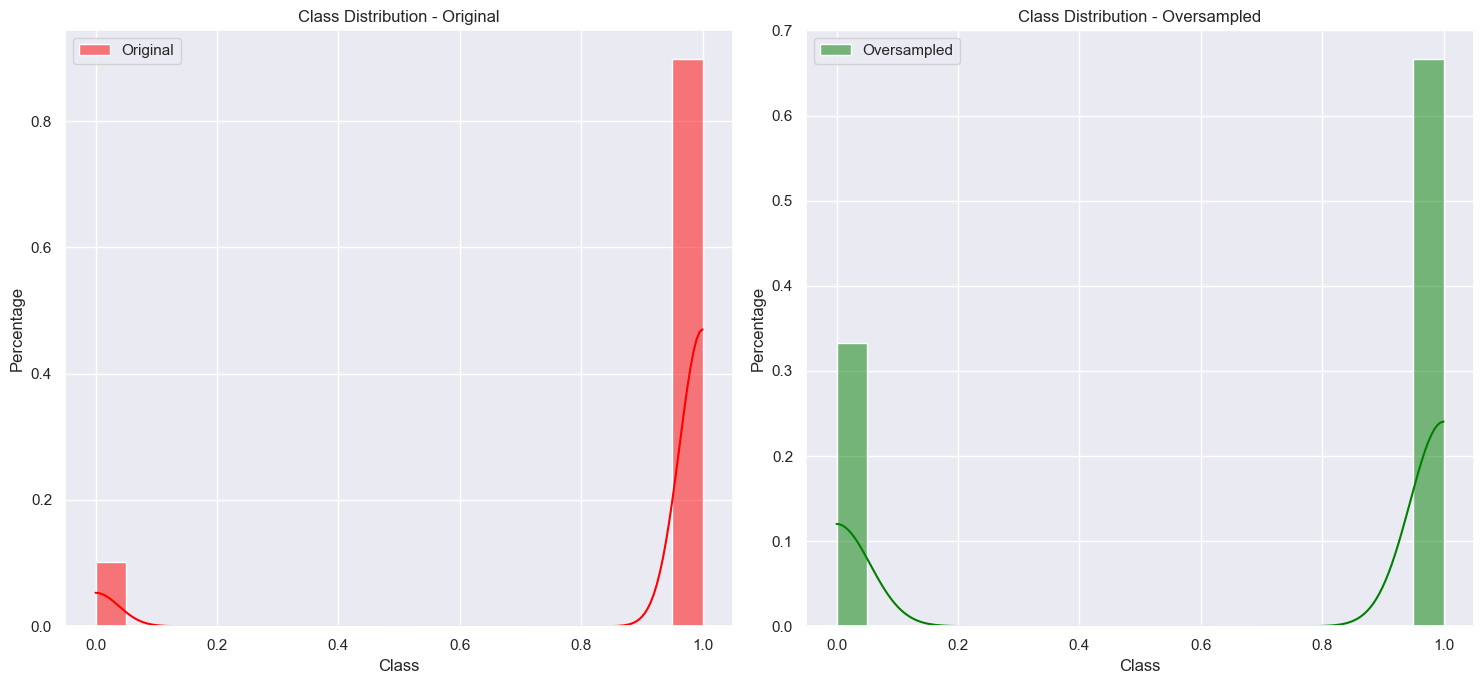

In [59]:

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# (31080, 1)
# (31080, 6)
# (7755, 6)
# (7755, 1)

# Configuración de semilla
SEED = 301
np.random.seed(SEED)

#Especificar la proporción deseada para cada clase
sampling_strategy = {
    0.0: 15000,
    1.0: 30000  # Ajustar a la cantidad original de muestras en la clase 1.0
}

# Crear un objeto RandomOverSampler con la proporción especificada
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=SEED)


# Seleccionar la primera columna de y_train como la variable objetivo
y_train_target_column = y_train.iloc[:, 0]

# Convertir las etiquetas a tipo entero (si no lo están)
y_train_target_column = y_train_target_column.astype(int)

# Aplicar oversampling a los conjuntos de entrenamiento
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train_target_column)

# Crear DataFrames con las etiquetas de clase
df_original = pd.DataFrame({'Class': y_train_target_column, 'Count': 1, 'Type': 'Original'})

# Convertir el array 2D a Serie de Pandas
y_train_resampled_series = pd.Series(y_train_resampled, name='Class')

df_oversampled = pd.DataFrame({'Class': y_train_resampled_series.values.flatten(), 'Count': 1, 'Type': 'Oversampled'})

# Combinar DataFrames para generar el gráfico
data = pd.concat([df_original, df_oversampled], ignore_index=True)

# Gráfico izquierdo - Original
sns.set(style="darkgrid")
palette = "Set2"

# Crear gráficos uno al lado del otro
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Gráfico izquierdo - Original
sns.histplot(data=df_original, x='Class', kde=True, color='red', label='Original', ax=axs[0], stat="probability", bins=20)
axs[0].set_title('Class Distribution - Original')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Percentage')
axs[0].legend()

# Gráfico derecho - Oversampled
sns.histplot(data=df_oversampled, x='Class', kde=True, color='green', label='Oversampled', ax=axs[1], stat="probability", bins=20)
axs[1].set_title('Class Distribution - Oversampled')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Percentage')
axs[1].legend()

# Ajustar diseño
plt.tight_layout()
plt.show()



### Modeling Predictor Variables

Shapes of training sets:
X_train: (31080, 6)
y_train: (31080, 1)

Shapes of testing sets:
X_test: (7755, 6)
y_test: (7755, 1)
X_train_resampled: (45000, 6)
y_train_resampled: (45000,)
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


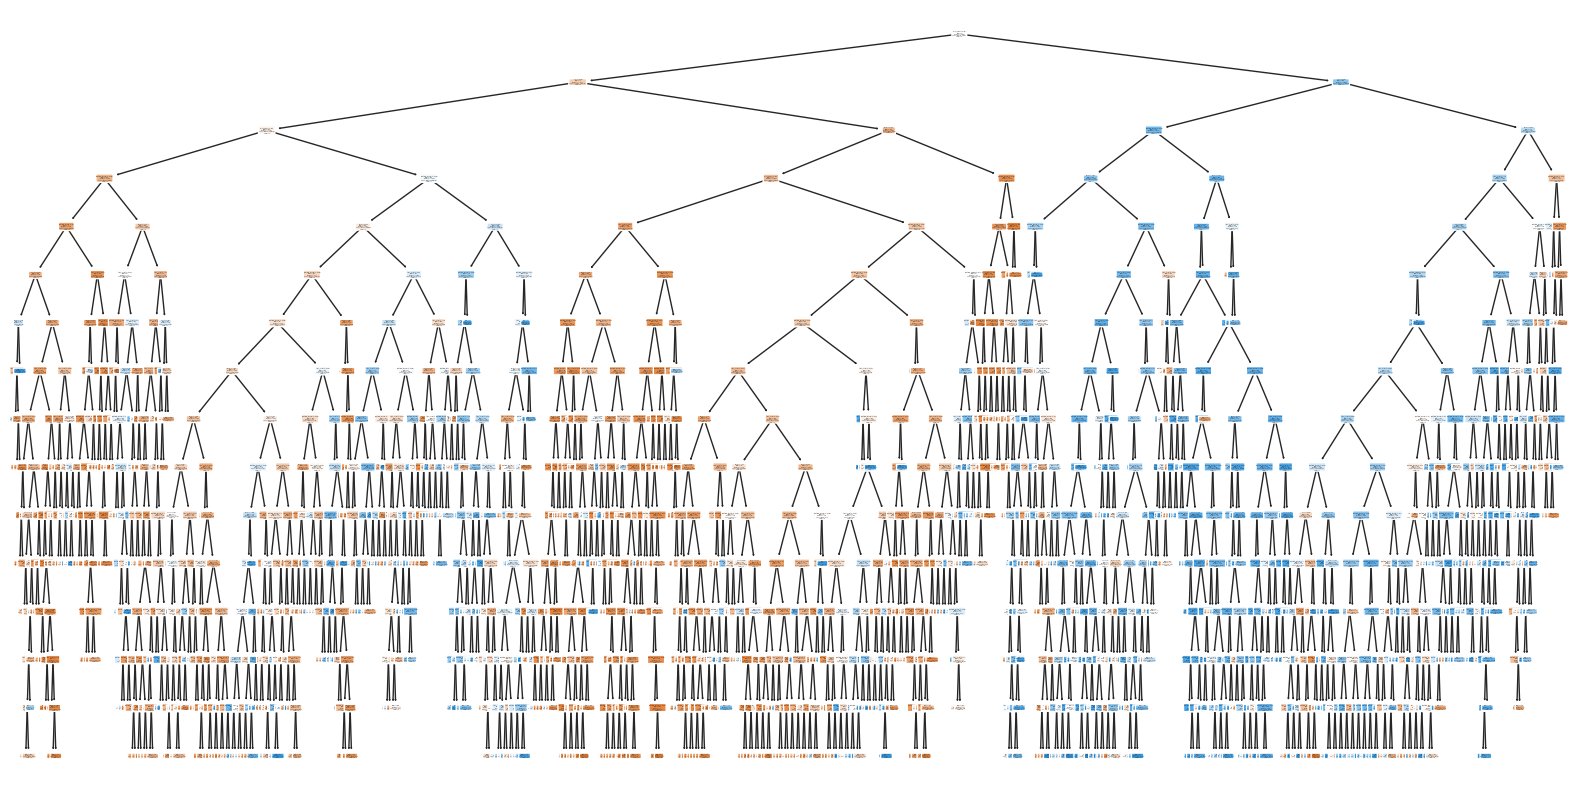

In [60]:
# Verificar las formas de los conjuntos resultantes
print("Shapes of training sets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nShapes of testing sets:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("X_train_resampled:", X_train_resampled.shape)
print("y_train_resampled:", y_train_resampled.shape)

X_train =X_train_resampled
y_train = y_train_resampled

def train_and_cross_validate_decision_tree(X_train, y_train, max_depth, min_samples_leaf=None):
    cv = StratifiedKFold(n_splits=10)
    if min_samples_leaf:
        modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=SEED)
    else:
        modelo = DecisionTreeClassifier(max_depth=max_depth, random_state=SEED)

    results = cross_validate(modelo, X_train, y_train, cv=cv, return_train_score=True, scoring='accuracy')
    
    for fold in range(10):
        train_score = results[f'train_score'][fold] * 100
        test_score = results[f'test_score'][fold] * 100
        print(f'Fold {fold + 1}: Árbol max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, training = {train_score:.2f}, testing = {test_score:.2f}')
    
    avg_train_score = results['train_score'].mean() * 100
    avg_test_score = results['test_score'].mean() * 100
    print(f'Average: Árbol max_depth = {max_depth}, min_samples_leaf = {min_samples_leaf}, average training = {avg_train_score:.2f}, average testing = {avg_test_score:.2f}')
    
    return max_depth, min_samples_leaf, avg_train_score, avg_test_score

# Función para realizar búsqueda de hiperparámetros
# Función para realizar búsqueda de hiperparámetros
def hyperparameter_search(X_train, y_train, espacio_de_parametros):
    buscar = GridSearchCV(DecisionTreeClassifier(random_state=SEED),
                          espacio_de_parametros,
                          cv=KFold(n_splits=5, shuffle=True))

    buscar.fit(X_train, y_train)
    resultados = pd.DataFrame(buscar.cv_results_)
    return resultados, buscar.best_params_


# Función para visualizar el árbol de decisión
# Función para visualizar el árbol de decisión
def visualize_tree(model, features, class_names=None):
    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, rounded=True, class_names=class_names, feature_names=features)
    plt.savefig('../datasets/images/tree.png')

espacio_de_parametros = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_leaf': [10, 12, 14, 16], #16, 32, 64, 128, 256
    'min_samples_split': [2, 5, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'criterion': ['gini', 'entropy']
}


# Realizar búsqueda de hiperparámetros
resultados_hyperparametros, mejores_hiperparametros = hyperparameter_search(X_train, y_train, espacio_de_parametros)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", mejores_hiperparametros)

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = DecisionTreeClassifier(**mejores_hiperparametros, class_weight='balanced',random_state=SEED)
mejor_modelo.fit(X_train, y_train)

# Visualizar el árbol de decisión con los mejores hiperparámetros
visualize_tree(mejor_modelo, X_train.columns, class_names=[str(i) for i in mejor_modelo.classes_])


In [61]:
# Realizar búsqueda de hiperparámetros
resultados_hyperparametros, mejores_hiperparametros = hyperparameter_search(X_train, y_train, espacio_de_parametros)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", mejores_hiperparametros)

# Mostrar resultados filtrados
resultados_filtrados = resultados_hyperparametros[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score', 'std_test_score']]
# Mostrar resultados filtrados ordenados por mean_test_score de mayor a menor
resultados_filtrados_ordenados = resultados_filtrados.sort_values(by='mean_test_score', ascending=False)
print("Resultados filtrados ordenados por mean_test_score de mayor a menor:")
print(resultados_filtrados_ordenados.head(15))

Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
Resultados filtrados ordenados por mean_test_score de mayor a menor:
    param_max_depth param_min_samples_leaf  mean_test_score  std_test_score
243              15                     10         0.776467        0.004751
242              15                     10         0.776467        0.004751
240              15                     10         0.776467        0.004751
241              15                     10         0.776467        0.004751
563              15                     10         0.775289        0.002858
562              15                     10         0.775289        0.002858
561              15                     10         0.775289        0.002858
560              15                     10         0.775289        0.002858
244              15                     12         0.774489        0.005310
247              15                  

In [68]:
y_train.head(5)

0    1
1    1
2    1
3    1
4    1
Name: recommend, dtype: int32

In [76]:
type(y_train)

pandas.core.series.Series

In [77]:
type(y_test)

pandas.core.frame.DataFrame

In [90]:
y_train = pd.DataFrame(y_train)
y_train.head(5)

,recommend
0,1
1,1
2,1
3,1
4,1


In [91]:
print("Columnas en y_train:", y_train.columns)
print("Columnas en y_test:", y_test.columns)

# Resto del código


Columnas en y_train: Index(['recommend'], dtype='object')
Columnas en y_test: Index(['recommend'], dtype='object')


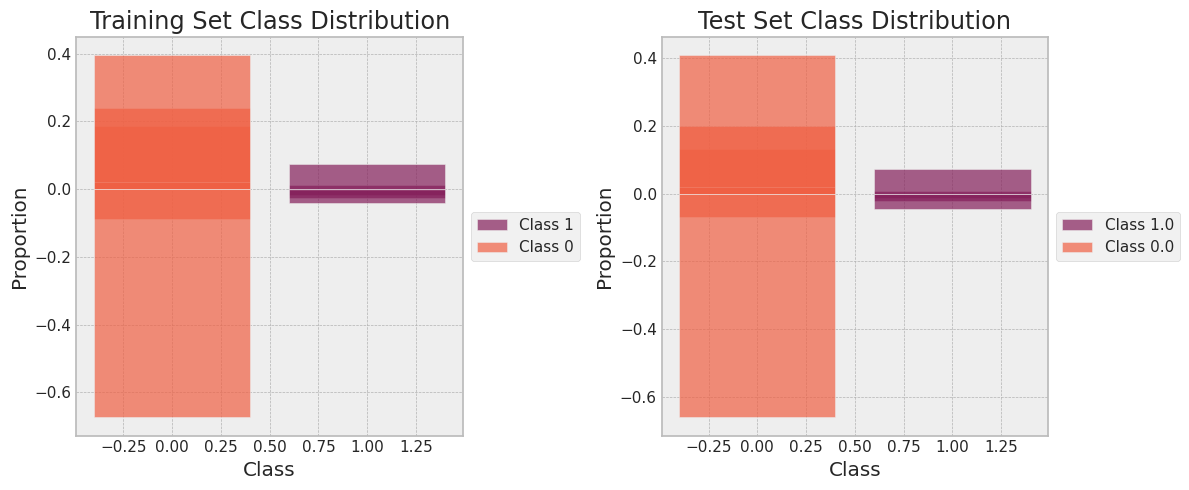

In [92]:
# Convertir las etiquetas de clase a listas
train_class_labels = list(y_train.iloc[:, 0].unique())
test_class_labels = list(y_test.iloc[:, 0].unique())

# Definir una paleta de colores para las clases
palette = sns.color_palette("rocket", len(train_class_labels))
plt.style.use('bmh')

# Crear una figura y ejes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Graficar la distribución de clases en conjunto de entrenamiento
for class_label, color in zip(train_class_labels, palette):
    class_data = X_train[y_train.iloc[:, 0] == class_label]
    axes[0].bar(class_label, class_data.mean(), color=color, alpha=0.7, label=f'Class {class_label}')

axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Proportion')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Graficar la distribución de clases en conjunto de prueba
for class_label, color in zip(test_class_labels, palette):
    class_data = X_test[y_test.iloc[:, 0] == class_label]
    axes[1].bar(class_label, class_data.mean(), color=color, alpha=0.7, label=f'Class {class_label}')

axes[1].set_title('Test Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Proportion')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Restaurar el estilo por defecto al final
plt.style.use('default')

plt.tight_layout()
plt.show()


### Historial de Modelos Preparados

In [93]:
# Imprimir todas las columnas disponibles
print("Columnas disponibles en resultados_hyperparametros:")
print(resultados_hyperparametros.columns)

# Imprimir los resultados sin filtrar columnas específicas
print("Resultados de búsqueda de hiperparámetros:")
print(resultados_hyperparametros.sort_values(by='mean_test_score', ascending=False))


Columnas disponibles en resultados_hyperparametros:
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_max_features',
       'param_min_samples_leaf', 'param_min_samples_split', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')
Resultados de búsqueda de hiperparámetros:
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
243       0.045885      0.001003         0.003797        0.000399   
242       0.047370      0.001955         0.004398        0.000489   
240       0.044771      0.000399         0.003801        0.000401   
241       0.045972      0.000896         0.003802        0.000402   
563       0.060763      0.004164         0.004598        0.000489   
..             ...           ...              ...             ...   
336

### Clasificación de datos

In [94]:
from sklearn.metrics import confusion_matrix, classification_report

# Predecir etiquetas en el conjunto de prueba
y_pred = mejor_modelo.predict(X_test)

# Imprimir el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.18      0.55      0.27       762
         1.0       0.94      0.72      0.81      6993

    accuracy                           0.70      7755
   macro avg       0.56      0.64      0.54      7755
weighted avg       0.86      0.70      0.76      7755



#### Matriz de Confusión para las Predicciones versus los datos de Prueba

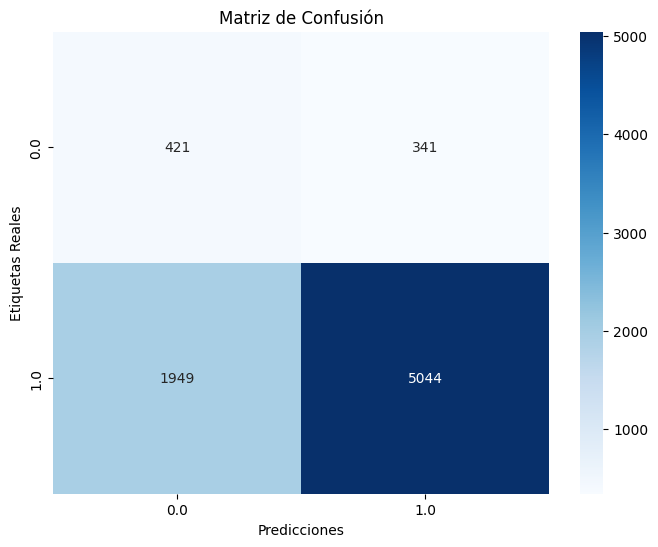

In [95]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
# conf_matrix = confusion_matrix(y_test_unidimensional, y_pred_prueba_unidimensional)
conf_matrix = confusion_matrix(y_test, y_pred)
# Crear un mapa de calor para la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión')
plt.show()

### Rendimiento en el Conjunto de Entrenamiento

In [96]:
from sklearn.model_selection import cross_val_score
from scipy.stats import sem, t
from numpy import mean

# Utilizar validación cruzada estratificada
cv = StratifiedKFold(n_splits=10)

# Realizar validación cruzada para obtener las métricas de rendimiento
cv_scores = cross_val_score(mejor_modelo, X_train, y_train, cv=cv)

# Calcular la precisión media
mean_accuracy = mean(cv_scores) * 100
print(f"Accuracy media {mean_accuracy:.2f}")

# Calcular el intervalo de confianza
confidence = 0.95
n = len(cv_scores)
m = mean(cv_scores)
std_err = sem(cv_scores)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

# Calcular el intervalo de confianza y mostrarlo
intervalo_confianza = (m - h, m + h)
print(f"Intervalo {confidence * 100:.2f}% {intervalo_confianza}")

# Imprimir el modelo entrenado
print(mejor_modelo)



Accuracy media 75.29
Intervalo 95.00% (0.7484228490452491, 0.757310484288084)
DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=10, random_state=301)


### Rendimiento en el conjunto de pruebas

In [97]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada en el conjunto de pruebas
cv_scores = cross_val_score(mejor_modelo, X_test, y_test, cv=5, scoring='accuracy')

# Imprimir los resultados de la validación cruzada
print("Resultados de Validación Cruzada en el Conjunto de Pruebas:")
print(cv_scores)
print(f"Promedio de Precisión: {cv_scores.mean():.2f}")


Resultados de Validación Cruzada en el Conjunto de Pruebas:
[0.73565442 0.71889104 0.72082527 0.73436493 0.724049  ]
Promedio de Precisión: 0.73


In [98]:
from sklearn.metrics import classification_report

# Entrenar el modelo con los mejores hiperparámetros
mejor_modelo = DecisionTreeClassifier(**mejores_hiperparametros, random_state=SEED)
mejor_modelo.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = mejor_modelo.predict(X_test)

# Imprimir informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))


Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.21      0.44      0.28       762
         1.0       0.93      0.82      0.87      6993

    accuracy                           0.78      7755
   macro avg       0.57      0.63      0.58      7755
weighted avg       0.86      0.78      0.81      7755



#### Resumen de Métricas

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predecir en el conjunto de prueba
y_pred = mejor_modelo.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Imprimir las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.78
Precision: 0.86
Recall: 0.78
F1 Score: 0.81


#### Exportar Modelo Predictivo

In [100]:
import joblib

# Guardar el modelo en la carpeta "models"
joblib.dump(mejor_modelo, '../datasets/models/mejor_modelo_decision_tree.joblib')

# Guardar los mejores hiperparámetros en la carpeta "hyperparameters"
joblib.dump(mejores_hiperparametros, '../datasets/models/mejores_hiperparametros_decision_tree.joblib')


['../datasets/models/mejores_hiperparametros_decision_tree.joblib']


#### Análisis del Modelo:<br>

**Matriz de Confusión y Reporte de Clasificación:**<br>

La matriz de confusión muestra el rendimiento del modelo en términos de predicciones correctas e incorrectas para cada clase.
El reporte de clasificación proporciona métricas más detalladas como precisión, recall y F1-score por clase.
Observaciones:

El modelo muestra una buena precisión (0.78) en clases, indicando que las predicciones positivas son son confiables.
La clases 0.0 y 1.0 tiene una aceptable precisión y recall, lo que sugiere que el modelo tiene capacidad para predecir estas clases en `0.21` y  `0.98`. La muestra para esta clase es baja `0.0`, lo que puede afectar las métricas en futuras estimaciones del modelo.
El modelo tiene un alto rendimiento global, con una precisión promedio ponderada de  `0.86` y un recall promedio ponderado de `0.78`.<br>

**Validación Cruzada en Conjunto de Entrenamiento:**<br>

La precisión media de la validación cruzada en el conjunto de entrenamiento es del `75%`, con un intervalo de confianza del `95%`.
Esta capacidad de  rendimiento en la validación cruzada indica que el modelo generaliza de forma acertada los datos no 
**Validación Cruzada en Conjunto de Pruebas:**<br>

La validación cruzada en el conjunto de pruebas muestra una precisión promedio baja del `75%`. Esto puede ser debido al balanceo en cantidad de muestras en de ambas clases, lo que afecta positivamente  la capacidad del modelo para generalizar.
Informe de Clasificación en Conjunto de Pruebas:

El modelo tiene una precisión del `75%` en el conjunto de pruebas, indicando un buen rendimiento en datos no vistos.
Las métricas detalladas muestran un buen equilibrio entre precisión, recall y F1-score para la mayoría de las clases.
Conclusión:

El modelo parece tener un rendimiento bueno en general, en equilibrio entre precisión y recall en la mayoría de las clases.
La aceptable precisión en la clases (..) podría deberse al balanceo de datos en la fase de entrenamiento para esa clase específica.
La validación cruzada en el conjunto de pruebas refleja completamente la capacidad del modelo debido a desafíos en la distribución de clases.

Se recomienda recopilar más datos y evaluar el modelo en  producción.